# DKRZ example

2024 copyright DKRZ licensed under CC BY-NC-SA 4.0 (https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en)

----

<br>

## 2023 Surface air temperature anomalies of Europe

2024 copyright DKRZ licensed under CC BY-NC-SA 4.0 (https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en)

----

### Description

This notebook demonstrates the data processing with python-cdo

- extract the temperature data for the year 2023
- compute the climatology data from the years 1991-2020
- compute the anomalies for the year 2023

In this example, we use the surface air temperature daily mean variable **tg** of the **E-OBS** dataset. The data extraction and computations in this notebook are done primarily using the **python-CDO** package.

----

### Data description

The data grid resolution used in this notebook is 0.25° x 0.25°.

From the E-OBS data documentation at CDS:

    The E-OBS daily gridded meteorological data for Europe from 1950 to present derived 
    from in-situ observations.
    Gridtype:    regular latlon
    Resolution:  0.1° x 0.1° and 0.25° x 0.25°
    Variables:   Mean temperature in °C

    We acknowledge the E-OBS dataset and the data providers in the ECA&D project 
    ( https://www.ecad.eu).
    Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. 2018: 
    An Ensemble Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. Atmos., 
    123. doi:10.1029/2017JD028200

    Download: https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.151d3ec6?tab=overview
    Copernicus Climate Change Service, Climate Data Store, (2020): 
    E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ 
    observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). 
    DOI: 10.24381/cds.151d3ec6 (Accessed on DD-MMM-YYYY)

----

### python-CDO:

For the computations in this notebook we use the python-CDO package, the Python bindings of CDO (Climate Data Operators). 

    Schulzweida, Uwe. (2023). CDO User Guide (2.3.0). Zenodo. https://doi.org/10.5281/zenodo.10020800

----

### Notes:

- The cartopy map projection Transverse Mercator with a given central_longitude=10. leads to a strange behavior of the cartopy.features. Use `ccrs.TransverseMercator(central_longitude=11.,central_latitude=50.) ` instead.

----

In [1]:
import os
import xarray as xr
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cdo import Cdo
cdo = Cdo()

### Function: add_copyright(ax)

Add the copyright und data information text to the figure.

In [2]:
def add_copyright(x=0.7, y=0.1, dy=0.011, fs=6):
    '''Add the copyright and data information to the figure.
    '''
    fig.text(x, y,       '© 2024 CC BY-NC-SA 4.0 4.0: DKRZ', fontsize=fs)
    fig.text(x, y-dy, 'Data: E-OBS doi:10.1029/2017JD028200', fontsize=fs)

### Function: add_colorbar()

Add a colorbar to the plot.

In [3]:
def add_colorbar(plot, bounds=None, cbar_labels=None, label=None, 
                 shrink=0.7, pad=0.06, hide=False, extend='both'):
    '''Add a colorbar to the plot.
    '''
    cbar = plt.colorbar(plot, shrink=shrink, pad=pad, extend=extend)

    if label is not None: cbar.set_label(label, rotation=270, labelpad=15)
    if bounds is not None: cbar.set_ticks(bounds)

    if cbar_labels is not None: 
        if hide:
            for i, x in enumerate(bounds):
                if i % 2:
                    cbar_labels[i] = ''
        cbar.set_ticklabels(cbar_labels)

    cbar.solids.set_edgecolor('white')
    cbar.solids.set_linewidth(1)
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(which='minor', length = 0)
    cbar.ax.tick_params(which='major', length = 0)

### E-OBS daily data

Open the dataset of the surface air temperature mean data, if it doesn't exist merge the single tg files using CDO.

In [4]:
dpath = os.environ['HOME']+'/data/E-OBS/'

files = dpath + 'tg_ens_mean_0.25deg_reg_*.nc'

In [5]:
tg_all = dpath + 'tg_0.25deg_1950-2023.nc'     #-- output file name

if not os.path.exists(tg_all): 
    print('--- tg_all: merged data does not exist')
    print('---         merge data ...')
    cdo.mergetime(input=f'{files}', options='-O', output=tg_all)

### Anomalies

#### 1. monthly mean

**Monthly means for 2023**

In [6]:
data_file = dpath + 'tg_2023_monthly_mean.nc'

if not os.path.exists(data_file):
    cdo.monmean(input=f'-selyear,2023 {tg_all}', 
                        options='-O --reduce_dim', output=data_file)

**Climatology**

Compute the 30-years monthly reference data using the time range 1991-2020.

In [7]:
ref_time = [1991, 2020]

In [8]:
clim_file = dpath + 'tg_clim_1991-2020_monthly_mean.nc'

if not os.path.exists(clim_file):
    cdo.ymonmean(input=f'-selyear,{ref_time[0]}/{ref_time[1]} {tg_all}', 
                        options='-O --reduce_dim', output=clim_file)

**Anomalies**

In [9]:
anom_file = dpath + 'tg_2023_anomaly_monthly_mean.nc'

if not os.path.exists(anom_file):
    cdo.sub(input=f'{data_file} {clim_file}', 
                        options='-O --reduce_dim', output=anom_file)

In [10]:
ds_anom = xr.open_dataset(anom_file)
#print(f'{ds_anom.tg.min().values}, {ds_anom.tg.max().values}')

lon = ds_anom.longitude
lat = ds_anom.latitude

#### 2. yearly mean

**Climatology**

In [11]:
climym_file = dpath + 'tg_clim_1991-2020_yearly_mean.nc'

if not os.path.exists(climym_file):
    cdo.yearmean(input=f'-selyear,{ref_time[0]}/{ref_time[1]} {tg_all}', 
                        options='-O --reduce_dim', output=climym_file)

**Data 2023**

In [12]:
dataym_file = dpath + 'tg_2023_yearly_mean.nc'

if not os.path.exists(dataym_file):
    cdo.yearmean(input=f'-selyear,2023 {tg_all}', 
                        options='-O --reduce_dim', output=dataym_file)

**Anomalies**

In [13]:
anomym_file = dpath + 'tg_2023_anomaly_yearly_mean.nc'

if not os.path.exists(anomym_file):
    cdo.sub(input=f'{dataym_file} {climym_file}', 
                        options='-O --reduce_dim', output=anomym_file)

In [14]:
ds_anomym = xr.open_dataset(anomym_file)

anom_ym = ds_anomym.tg.squeeze()

print(f'{anom_ym.min().values}, {anom_ym.max().values}')

-3.5999999046325684, 5.559999942779541


Use only values within the chosen bounds.

In [15]:
anom_ym_cut = anom_ym.where(((anom_ym > -3.) & (anom_ym < 3.)), np.nan)

print(f'{anom_ym_cut.min().values}, {anom_ym_cut.max().values}')

-2.9700000286102295, 2.990000009536743


### Plot 2023 yearly mean anomalies


#### Colormap

In [16]:
color_list4 = ['darkblue', 'lightblue', 'white', 'lightyellow', 'orange',  'firebrick']

nodes = [0.0, 0.3, 0.5, 0.5, 0.8,  1.0]

cmap = mcolors.LinearSegmentedColormap.from_list('mybluewhitered', list(zip(nodes, color_list4)))
#cmap

#### Data norm and colorbar labels

In [17]:
bounds = [-3.00, -2.50, -2.00, -1.50, -1.00, -0.75, -0.50, -0.25,  0., 
           0.25,  0.50,  0.75,  1.00,  1.50,  2.00 , 2.50,  3.00 ]

norm = mcolors.BoundaryNorm(bounds, cmap.N)

cbar_labels = [f'{x:.2f}' for x in bounds]

#### Map projection and data transformation

In [18]:
projection = ccrs.TransverseMercator(central_longitude=11.,
                                    central_latitude=50.)
transform = ccrs.PlateCarree()

#### Plot

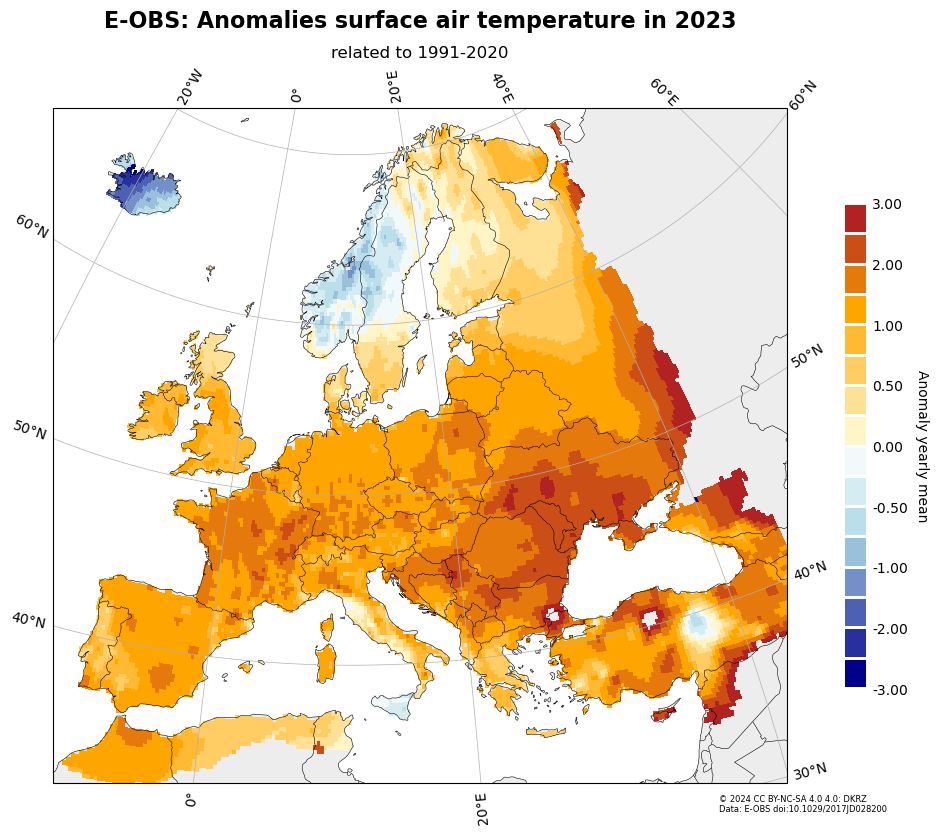

In [19]:
fig, ax = plt.subplots(figsize=(12,9), 
                       subplot_kw=dict(projection=projection))

#-- zoom in map, draw coastlines, fill ocean and land, draw gridlines
ax.set_extent([lon.min()+31., lon.max()-35., lat.min()+6., lat.max()-5])
ax.coastlines(resolution='50m', lw=0.4)
ax.gridlines(draw_labels=True, lw=0.5)
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='white')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='gainsboro', alpha=0.5)
ax.add_feature(cfeature.BORDERS, lw=0.4);

#-- generate the raster plot
plot = ax.pcolormesh(lon, lat, anom_ym_cut, 
                     cmap=cmap, 
                     norm=norm,
                     transform=transform)

#-- add colorbar
add_colorbar(plot, bounds=bounds, cbar_labels=cbar_labels, 
             label='Anomaly yearly mean',
             shrink=0.7, pad=0.06,
             hide=True,
             extend='neither')

#-- add and center title and suptitle strings above axis
ax_bbox = ax.get_position()
middle = ax_bbox.x0 + (ax_bbox.x1 - ax_bbox.x0)/2

plt.suptitle('E-OBS: Anomalies surface air temperature in 2023',
              fontsize=16, weight='bold', x=middle)
ax.set_title('related to 1991-2020', fontsize=12)

#-- add copyright and data information
add_copyright(x=0.68, y=0.1, dy=0.011)

#-- save figure to PNG file
fig.savefig('plot_anomalies_surface_air_temperature_in_2023_yearly_mean', 
            bbox_inches='tight', facecolor='white', dpi=300);

----

### Plot 2023 monthly anomalies

In [20]:
var_anom_mon = ds_anom.tg
var_anom_mon.attrs['units'] = 'Anomalies in °C'

#### Data norm and colorbar labels

In [21]:
bounds = [-7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.00, -2.50, 
          -2.00, -1.50, -1.00, -0.75, -0.50, -0.25,  0., 
           0.25,  0.50,  0.75,  1.00,  1.50,  2.00 , 
          2.50,  3.00 , 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

norm = mcolors.BoundaryNorm(bounds, cmap.N)

cbar_labels = [f'{x:.2f}' for x in bounds]
cbar_title  = var_anom_mon.units

#### Plot

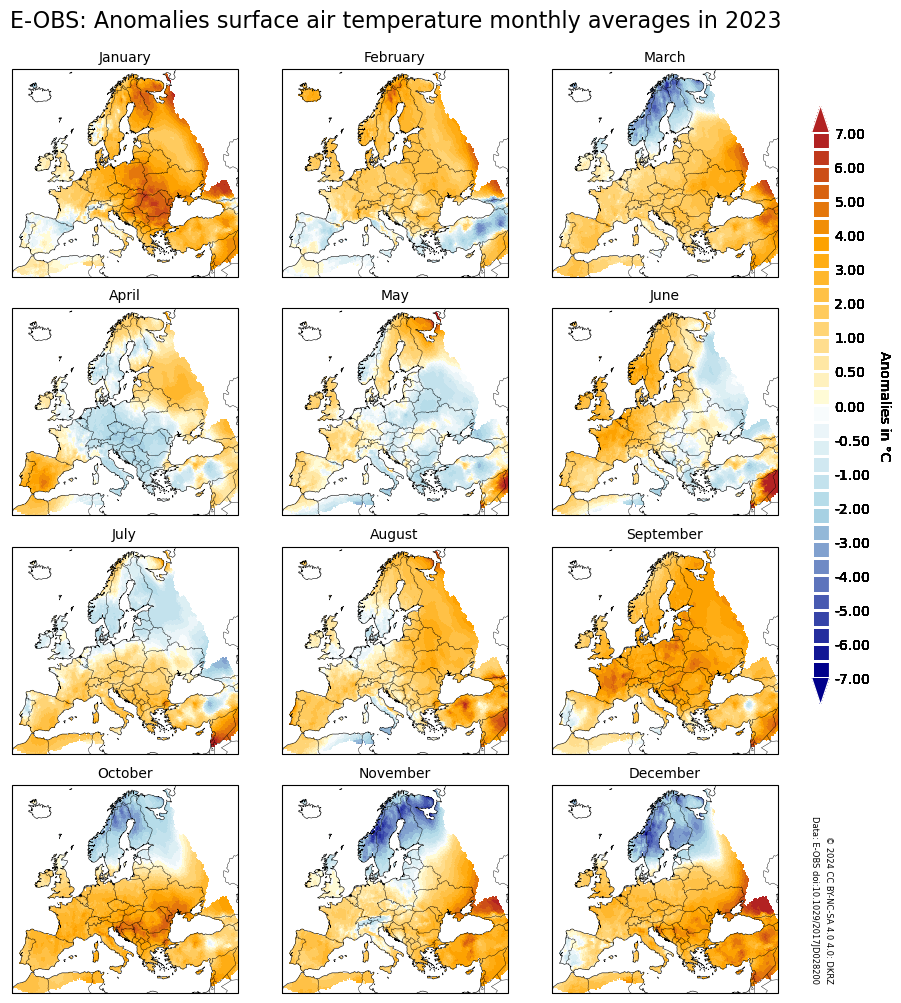

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12),
                         subplot_kw=dict(projection=projection))

fig.suptitle('E-OBS: Anomalies surface air temperature monthly averages in 2023', 
             x=0.142, y=0.93, ha='left', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.set_extent([lon.min()+31., lon.max()-35., lat.min()+6., lat.max()-5])
    ax.coastlines(resolution='50m', lw=0.4)
    ax.add_feature(cfeature.BORDERS, lw=0.3)
    
    ax.set_title(f'{var_anom_mon.time[i].dt.strftime("%B").values}', fontsize=10)
    
    plot = ax.pcolormesh(lon, lat, var_anom_mon.isel(time=i), 
                         cmap=cmap, 
                         norm=norm,
                         transform=transform)
    
    plt.subplots_adjust(wspace=0.0, hspace=0.15)
    
    #-- add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.35, 0.015, 0.5])
    cbar = fig.colorbar(plot, cax=cbar_ax, cmap=cmap, norm=plt.Normalize(-15,15), 
                        extend='both')

    cbar.set_label(cbar_title, rotation=270, labelpad=15, weight='normal')
    cbar.set_ticks(bounds)
    cbar.ax.tick_params(axis='both', length=0)

    #-- hide every 2nd cbar tick label
    for i, x in enumerate(bounds):
        if i % 2:
            cbar_labels[i] = ''
    cbar.set_ticklabels(cbar_labels, weight='normal')
    
    cbar.solids.set(edgecolor='white', linewidth=1)
    cbar.outline.set(edgecolor='white', linewidth=1)

dx = 0.011
x, y = 0.82, 0.12
fig.text(x,      y, '© 2024 CC BY-NC-SA 4.0 4.0: DKRZ', rotation=270, fontsize=6)
fig.text(x-dx,   y, 'Data: E-OBS doi:10.1029/2017JD028200', rotation=270, fontsize=6)

fig.savefig('plot_anomalies_surface_air_temperature_2023_monthly_mean.png', 
             bbox_inches='tight', facecolor='white', dpi=300);